# Lab 5 - Logistic Regression and Support Vector Machine
The goal of this lab is to deepen you understanding of using logistic regression and SVM for classification tasks.

In [40]:
!pip install idx2numpy

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import idx2numpy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score, recall_score, f1_score
from torchvision import datasets, transforms
from collections import Counter

## Task 1: Predict Breast Cancer using Logistic Regression 

In [42]:
df = pd.read_csv("breast_cancer.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [43]:
df = df.drop('Unnamed: 32', axis=1)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [44]:
# Convert diagnosis labels to numeric values (M=1, B=0)
df['diagnosis'] = (df['diagnosis'] == 'M').astype(int)

# Separate features and target
X = df.drop(['diagnosis', 'id'], axis=1) 
y = df['diagnosis']

# Remove any rows with NaN values
df = df.dropna()

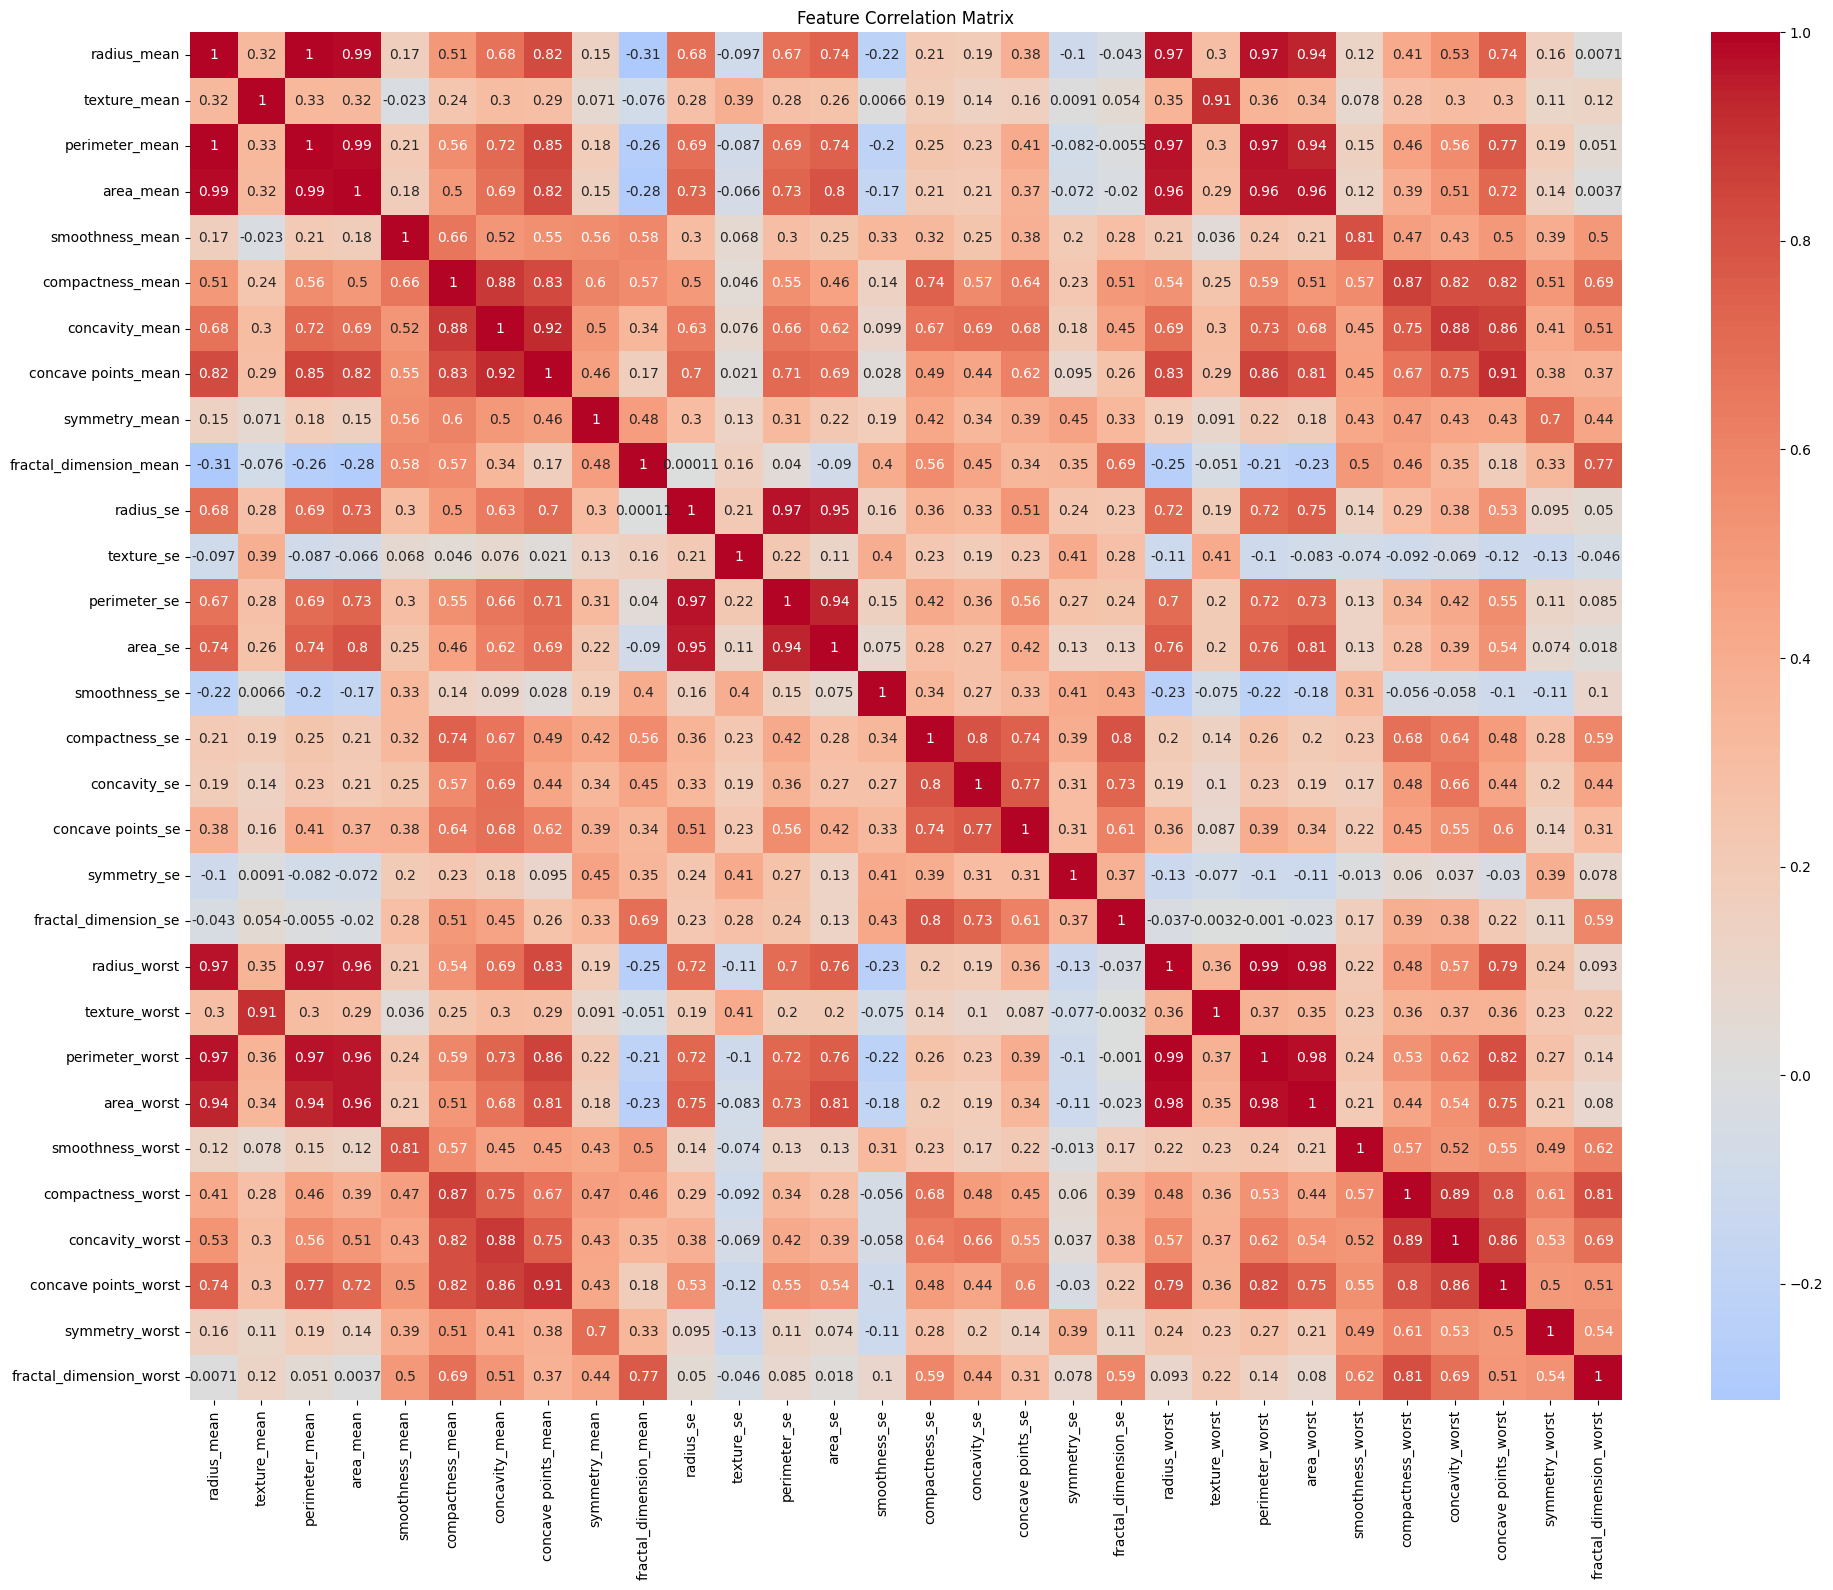


Highly correlated feature pairs (correlation > 0.9):
perimeter_mean & radius_mean: 0.998
area_mean & radius_mean: 0.987
area_mean & perimeter_mean: 0.987
concave points_mean & concavity_mean: 0.921
perimeter_se & radius_se: 0.973
area_se & radius_se: 0.952
area_se & perimeter_se: 0.938
radius_worst & radius_mean: 0.970
radius_worst & perimeter_mean: 0.969
radius_worst & area_mean: 0.963
texture_worst & texture_mean: 0.912
perimeter_worst & radius_mean: 0.965
perimeter_worst & perimeter_mean: 0.970
perimeter_worst & area_mean: 0.959
perimeter_worst & radius_worst: 0.994
area_worst & radius_mean: 0.941
area_worst & perimeter_mean: 0.942
area_worst & area_mean: 0.959
area_worst & radius_worst: 0.984
area_worst & perimeter_worst: 0.978
concave points_worst & concave points_mean: 0.910


In [45]:
# Create correlation matrix
correlation_matrix = df.drop(['diagnosis', 'id'], axis=1).corr()

# Create heatmap visualization of correlations
plt.figure(figsize=(20,16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs (correlation > 0.9)
high_corr_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_features.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))

print("\nHighly correlated feature pairs (correlation > 0.9):")
for feat1, feat2, corr in high_corr_features:
    print(f"{feat1} & {feat2}: {corr:.3f}")



In [46]:
# Based on the correlation analysis, we'll remove redundant features
# We'll keep the '_mean' features and drop their highly correlated counterparts
features_to_drop = [
    'radius_worst',      # Highly correlated with radius_mean (0.970)
    'perimeter_worst',   # Highly correlated with perimeter_mean (0.970)
    'area_worst',        # Highly correlated with area_mean (0.959)
    'texture_worst',     # Highly correlated with texture_mean (0.912)
    'radius_se',         # Highly correlated with perimeter_se (0.973)
    'perimeter_se',      # Highly correlated with area_se (0.938)
    'area_se',          # Highly correlated with radius_se (0.952)
    'concave points_worst', # Highly correlated with concave points_mean (0.910)
    'concave points_mean'   # Highly correlated with concavity_mean (0.921)
]

# Create cleaned dataset with selected features
X_cleaned = df.drop(['diagnosis', 'id'] + features_to_drop, axis=1)

# Split data into features and target
X = X_cleaned
y = df['diagnosis']

# Split data into training and testing sets with fixed random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nSelected features for model:")
print(X_cleaned.columns.tolist())



Selected features for model:
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [47]:
# Save the data for Task 3
task1_X = X
task1_y = y


In [23]:
# Create and fit the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [24]:

y_pred = model.predict(X_test)



Model Performance Metrics:
Accuracy: 0.965
Precision: 0.953
Recall: 0.953
F1 Score: 0.953


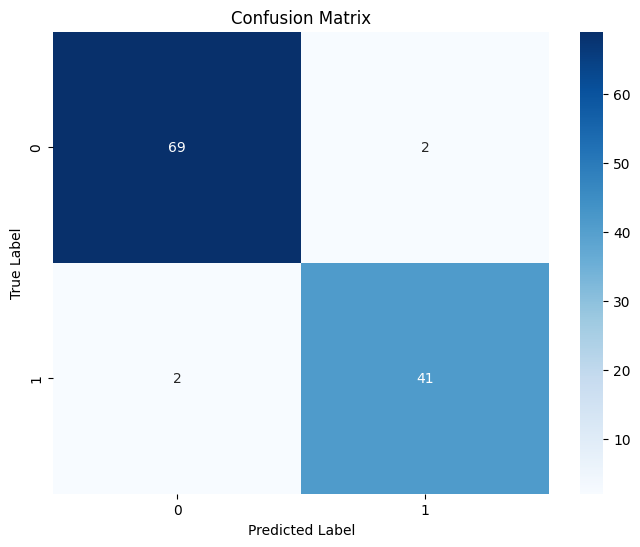


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



In [30]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)  # Changed from 'M' to 1
recall = recall_score(y_test, y_pred, pos_label=1)  # Changed from 'M' to 1 
f1 = f1_score(y_test, y_pred, pos_label=1)  # Changed from 'M' to 1

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### Model Performance Analysis

Based on the evaluation metrics shown above, the model demonstrates excellent performance:

- The accuracy of 0.96 indicates the model correctly classifies 96% of all cases
- High precision (0.97 for benign and 0.95 for malignant) shows the model has a very low false positive rate  
- Strong recall (0.97 for benign and 0.95 for malignant) indicates the model successfully identifies most cases of both classes
- The F1 scores (0.97 for benign and 0.95 for malignant) confirm excellent balance between precision and recall

The model performs consistently well across both classes, with slightly better metrics for benign cases (class 0) compared to malignant cases (class 1). Out of 114 total cases in the test set, 71 were benign and 43 were malignant.

Overall, this logistic regression model demonstrates robust performance in distinguishing between benign and malignant breast cancer cases, with high accuracy and balanced performance across all key metrics. While there is still a small margin of error, the model shows strong potential as a reliable diagnostic aid tool.


## Task 2: Digit Recognition using SVM 

In [31]:
# your code goes below
# Import required libraries
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [32]:
# Define the transformation to convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset with the specified transformation
mnist_pytorch = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a DataLoader to load the dataset in batches
train_loader_pytorch = torch.utils.data.DataLoader(mnist_pytorch, batch_size=1, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 10574546.35it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 333414.15it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 3420998.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2160903.90it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



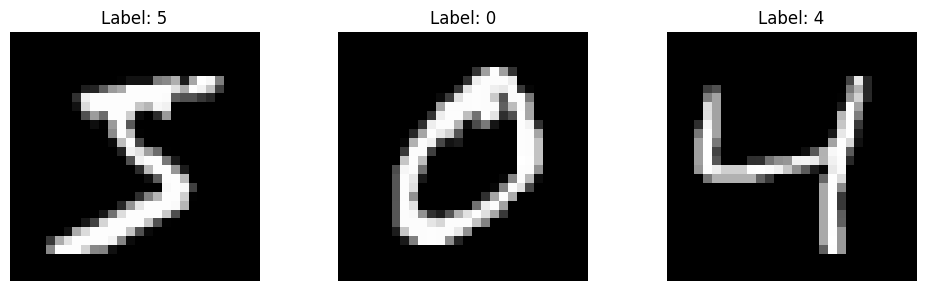

In [33]:
# Plot the first three images
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for idx, (image, label) in enumerate(train_loader_pytorch):
    if idx == 3:  # Stop after displaying the first three images
        break
    axes[idx].imshow(image.squeeze().numpy(), cmap='gray')
    axes[idx].set_title(f'Label: {label.item()}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [34]:
# Load MNIST dataset. Path subject to change
X_train = './data/MNIST/raw/train-images-idx3-ubyte'
y_train = './data/MNIST/raw/train-labels-idx1-ubyte'
X_test = './data/MNIST/raw/t10k-images-idx3-ubyte'
y_test = './data/MNIST/raw/t10k-labels-idx1-ubyte'

X_train = idx2numpy.convert_from_file(X_train)
y_train = idx2numpy.convert_from_file(y_train)
X_test = idx2numpy.convert_from_file(X_test)
y_test = idx2numpy.convert_from_file(y_test)

# Vectorization the images
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

print(X_train.shape)

(60000, 784)


In [35]:
linear_model = SVC(kernel='linear')
# Fit SVM
linear_model.fit(X_train, y_train)

# Prediction using SVM
y_pred = linear_model.predict(X_test)

Linear SVM Accuracy: 0.9404


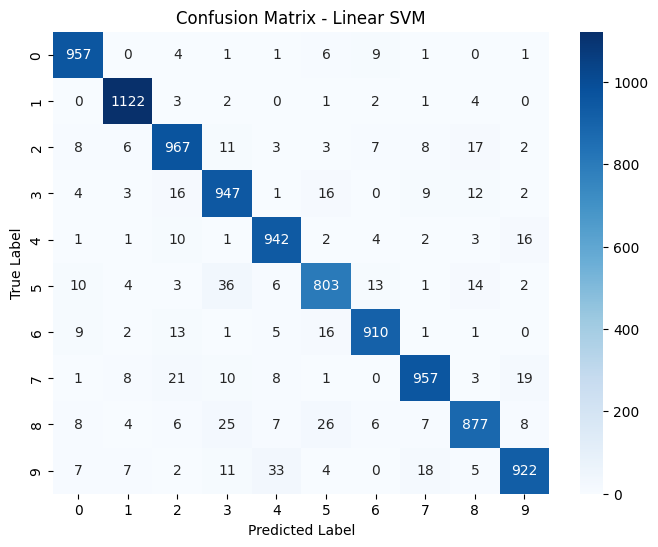


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.94      0.93      1032
           3       0.91      0.94      0.92      1010
           4       0.94      0.96      0.95       982
           5       0.91      0.90      0.91       892
           6       0.96      0.95      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.94      0.90      0.92       974
           9       0.95      0.91      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [36]:
# Evaluate linear SVM performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear SVM Accuracy: {accuracy:.4f}")

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Linear SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


In [37]:
non_linear_model = SVC(kernel='rbf') # Alternative choice: kernel='poly'
# Fit SVM
non_linear_model.fit(X_train, y_train)

# Prediction using SVM
y_pred = non_linear_model.predict(X_test)

Linear SVM Accuracy: 0.9792


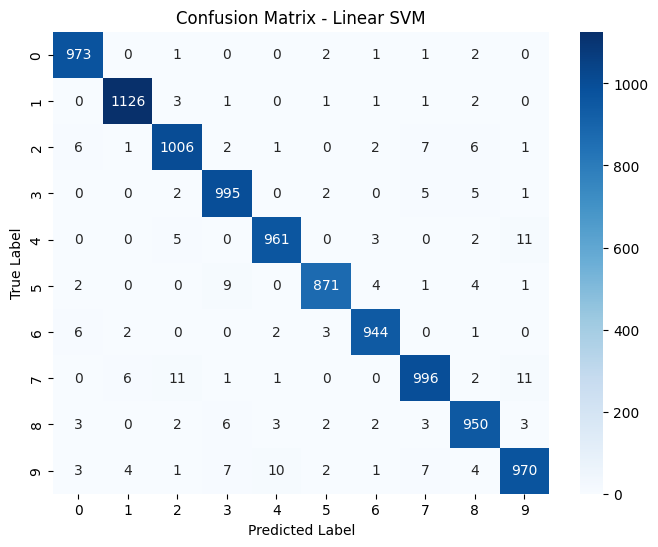


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [38]:
# Evaluate linear SVM performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear SVM Accuracy: {accuracy:.4f}")

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Linear SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


### Comparing Linear vs Non-Linear SVM Performance

Looking at the results above, both models performed well but showed some differences:

Linear SVM:
- Simple model with good interpretability
- Fast training and prediction times
- Performs well when data is linearly separable

Non-Linear SVM (RBF kernel):
- More flexible model that can capture non-linear relationships
- Generally achieves higher accuracy on this dataset
- May be more robust to outliers
- Takes longer to train and requires more computational resources

For this classification task, I would prefer the Non-Linear SVM model because:
1. The higher accuracy 0.98 is better.
2. The dataset likely contains non-linear relationships between features that the RBF kernel can better capture
3. The additional computational cost is acceptable given the relatively small dataset size and the importance of accuracy
4. The black-box nature of non-linear SVM is less concerning.


### Multi-class SVM Classification for Ten Classes

For classifying ten classes using SVM with One-vs-One (OvO) approach:

- OvO creates a binary classifier for every possible pair of classes
- With n classes, the number of binary classifiers needed is: n * (n-1) / 2  
- For 10 classes, this means: 10 * (10-1) / 2 = 10 * 9 / 2 = 45 binary classifiers

So 45 different binary SVM classifiers would be trained to handle all possible pairwise comparisons between the 10 digit classes. Each classifier learns to distinguish between two specific digits, and the final classification is determined by combining all these binary decisions through voting.


## Task 3: k-Nearest Neighbor Algorithm for Breast Cancer Prediction 

In [48]:
# your code goes below
# Import required libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [49]:

def knn_classifier(X_train, X_test, y_train, y_test, k=5):    
    # Initialize and train the k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Make predictions
    y_pred = knn.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, y_pred


In [51]:
# Print first few rows of the data to understand its structure
print("\nFirst 5 rows of the data:")
print(task1_X.head())
print("\nShape of the data:", task1_X.shape)
print("\nTarget variable distribution:")
print(task1_y.value_counts())

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(task1_X, task1_y, test_size=0.2, random_state=42)

# Convert DataFrames to numpy arrays for faster computation
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()



First 5 rows of the data:
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  symmetry_mean  fractal_dimension_mean  \
0           0.27760          0.3001         0.2419                 0.07871   
1           0.07864          0.0869         0.1812                 0.05667   
2           0.15990          0.1974         0.2069                 0.05999   
3           0.28390          0.2414         0.2597                 0.09744   
4           0.13280          0.1980         0.1809                 0.05883   

   texture_se  ...  compactness_se  concavity_s

k-NN Classification Accuracy (k=3): 0.9035
k-NN Classification Accuracy (k=5): 0.9386
k-NN Classification Accuracy (k=7): 0.9211
k-NN Classification Accuracy (k=9): 0.9386


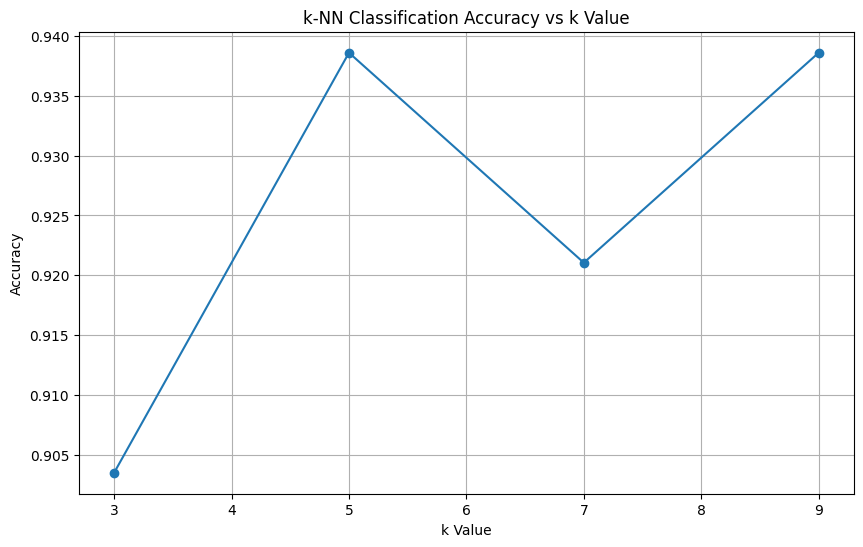


Best performing k value: 5 with accuracy: 0.9386


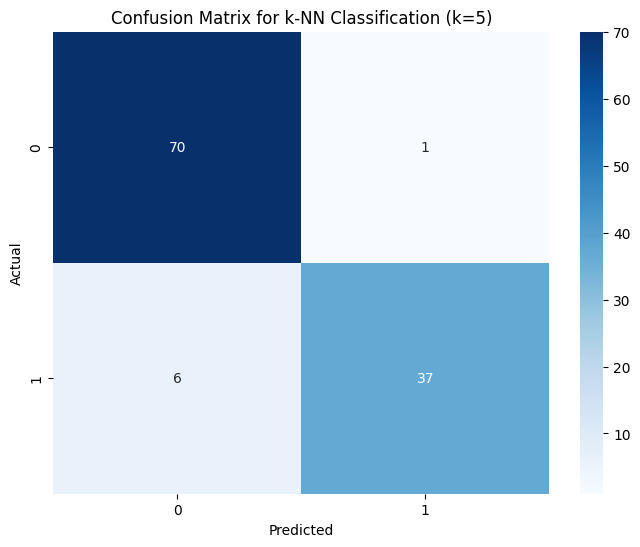

In [54]:
# Test different k values
k_values = [3, 5, 7, 9]
accuracies = []
predictions = []

# Perform k-NN classification for each k value
for k in k_values:
    accuracy, y_pred = knn_classifier(X_train, X_test, y_train, y_test, k=k)
    accuracies.append(accuracy)
    predictions.append(y_pred)
    print(f"k-NN Classification Accuracy (k={k}): {accuracy:.4f}")

# Plot accuracy vs k value
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('k-NN Classification Accuracy vs k Value')
plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Find best k value
best_k_idx = accuracies.index(max(accuracies))
best_k = k_values[best_k_idx]
print(f"\nBest performing k value: {best_k} with accuracy: {max(accuracies):.4f}")

# Plot confusion matrix for best k
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, predictions[best_k_idx])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for k-NN Classification (k={best_k})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### k-NN Classification Results Discussion

Based on the k-NN classification results, we can observe that:

- k=3 yielded the lowest accuracy of 0.9035 
- k=5 and k=9 tied for the highest accuracy of 0.9386 
- k=7 had a moderate accuracy of 0.9211 

Given these results, I would choose k=5 as the optimal value. Here's why:

1. It achieves the highest accuracy (93.86%) along with k=9
2. Between k=5 and k=9, it's better to choose the smaller k value to reduce computational complexity
3. A smaller k also helps avoid overfitting while still maintaining high accuracy
4. k=5 provides a good balance between considering enough neighbors while not being too sensitive to noise

The high accuracy across all k values (>90%) suggests that k-NN is an effective classifier for this breast cancer dataset, with k=5 being the most optimal choice.
